문제 : https://dacon.io/competitions/open/235594/overview/description


1. Model
    - Vanilla CNN
    - VGG
    - Spinal VGG
    - Resnet

2. Optimizer
    - SGD
    - SAM
    - Adam
        
3. Voting
    - Majority voting

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


# dataset load  
https://dacon.io/competitions/open/235594/codeshare/4175?page=1&dtype=recent

In [ ]:
class train_Dataset(Dataset):
    def __init__(self, data, transform = None):
        self.fashion_mnist = list(data.values)
        self.transform = transform
        label, img = [], []

        for one_line in self.fashion_mnist:
            label.append(one_line[0])
            img.append(one_line[1:])

        self.label = np.asarray(label)
        self.img = np.asarray(img).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL).astype('float32')

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        label, img = self.label[idx], self.img[idx]
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [ ]:
class test_Dataset(Dataset):
    def __init__(self, data, transform = None):
        self.fashion_mnist = list(data.values)
        self.transform = transform
        img = []

        for one_line in self.fashion_mnist:
            img.append(one_line[:])

        self.img = np.asarray(img).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL).astype('float32')

    def __len__(self):
        return len(self.fashion_mnist)

    def __getitem__(self, idx):
        img = self.img[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img

In [ ]:
train_temp = pd.read_csv("/content/drive/MyDrive/personal/fashion_mnist/data/train.csv", index_col='index')
test = pd.read_csv("/content/drive/MyDrive/personal/fashion_mnist/data/test.csv", index_col='index')

In [ ]:
train_temp = train_temp.sample(frac=1).reset_index(drop=True)

In [ ]:
train = train_temp[:48000]
valid = train_temp[48000:].reset_index(drop=True)

In [ ]:
valid

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,0,0,0,0,0,0,0,0,0,...,99,110,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,151,150,148,153,117,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,254,201,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,9,0,0,0,0,0,0,0,0,0,...,0,1,6,0,0,0,0,0,0,0
11996,6,0,0,0,0,0,0,0,0,21,...,67,33,18,12,3,0,0,0,0,0
11997,1,0,0,0,0,0,0,0,0,0,...,187,0,0,0,0,0,0,0,0,0
11998,2,0,0,0,0,0,0,1,1,0,...,3,3,0,0,167,198,51,0,0,0


In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])


In [ ]:
IMAGE_SIZE = 28
batch_size = 64
CHANNEL = 1

In [ ]:
Train_data = train_Dataset(train, transform=transform)
Test_data = test_Dataset(test, transform=transform)
Valid_data = train_Dataset(valid, transform=transform)

In [ ]:

# load training set, test set 
train_loader = torch.utils.data.DataLoader(Train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(Test_data, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(Valid_data, batch_size=batch_size, shuffle=False)


In [ ]:
for x, y in train_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Vanilla CNN 
https://github.com/Yuheon/Sharpness-Aware-Minimization

In [ ]:


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        )
        
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3)
        )
        
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        

    def forward(self, x):
        x= self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.layer4(x)
        x = self.fc2(x)
        
        return x

In [ ]:

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
    
    
    # epsilon hat, p = 2
    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12) # prevent / 0

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    # update weight : wt+1 = wt - eta * g
    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()


    # caculate 2 norm of gradient Ls(w)
    def _grad_norm(self): 
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        (1.0 * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
epochs = 100
learning_rate = 0.001

## model with SGD

In [ ]:
model_with_SGD = CNN().to(device)
optimizer_SGD = torch.optim.SGD(model_with_SGD.parameters(), lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sgd_train_loss = []
sgd_train_acc = []

# sgd_valid_loss = []
sgd_valid_acc = []

for epoch in range(epochs):
    model_with_SGD.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        #print(X.shape)
        optimizer_SGD.zero_grad()
        hypothesis = model_with_SGD(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_SGD.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # sgd_train_loss.append(total_loss / len(train_loader.dataset))     
    sgd_train_acc.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_with_SGD.eval()
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_with_SGD(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # sgd_valid_loss.append(total_loss / len(valid_loader.dataset))
    sgd_valid_acc.append(100. * correct / len(valid_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sgd_train_acc[-1], sgd_valid_acc[-1]))
            
        

Epoch : 1, Training Accuracy : 80.63%,  valid Accuracy : 87.22% 

Epoch : 2, Training Accuracy : 87.52%,  valid Accuracy : 88.58% 

Epoch : 3, Training Accuracy : 89.31%,  valid Accuracy : 89.66% 

Epoch : 4, Training Accuracy : 90.24%,  valid Accuracy : 90.12% 

Epoch : 5, Training Accuracy : 91.12%,  valid Accuracy : 89.83% 

Epoch : 6, Training Accuracy : 91.91%,  valid Accuracy : 90.62% 

Epoch : 7, Training Accuracy : 92.61%,  valid Accuracy : 90.16% 

Epoch : 8, Training Accuracy : 93.05%,  valid Accuracy : 89.78% 

Epoch : 9, Training Accuracy : 93.74%,  valid Accuracy : 90.55% 

Epoch : 10, Training Accuracy : 94.13%,  valid Accuracy : 90.69% 

Epoch : 11, Training Accuracy : 94.55%,  valid Accuracy : 90.54% 

Epoch : 12, Training Accuracy : 95.02%,  valid Accuracy : 90.03% 

Epoch : 13, Training Accuracy : 95.27%,  valid Accuracy : 90.28% 

Epoch : 14, Training Accuracy : 95.77%,  valid Accuracy : 89.88% 

Epoch : 15, Training Accuracy : 96.11%,  valid Accuracy : 90.15% 

Epoc

##Model with SAM

In [ ]:


model_with_SAM = CNN().to(device)

base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer_SAM = SAM(model_with_SAM.parameters(), base_optimizer, lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sam_train_loss = []
sam_train_acc = []

# sam_test_loss = []
sam_valid_acc = []


for epoch in range(epochs):
    
    model_with_SAM.train()
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        # first forward-backward pass
        
        hypothesis = model_with_SAM(X)
        
        loss = criterion(hypothesis, Y)  # use this loss for any training statistics
        loss.backward()
        optimizer_SAM.first_step(zero_grad=True)

        # second forward-backward pass
        
        criterion(model_with_SAM(X), Y).backward()  # make sure to do a full forward pass
        optimizer_SAM.second_step(zero_grad=True)
        
        predicted = torch.argmax(hypothesis, 1)
        correct += (predicted == Y).sum().item()
        
    sam_train_acc.append(100. * correct / len(train_loader.dataset))
    
    
    
    correct = 0
    with torch.no_grad():
        
        model_with_SAM.eval()
        
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            hypothesis = model_with_SAM(X)
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
    
    sam_valid_acc.append(100. * correct / len(valid_loader.dataset))

    
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sam_train_acc[-1], sam_valid_acc[-1]))
        
        


Epoch : 1, Training Accuracy : 70.98%,  valid Accuracy : 82.69% 

Epoch : 2, Training Accuracy : 83.43%,  valid Accuracy : 84.92% 

Epoch : 3, Training Accuracy : 85.39%,  valid Accuracy : 86.08% 

Epoch : 4, Training Accuracy : 86.87%,  valid Accuracy : 87.15% 

Epoch : 5, Training Accuracy : 87.83%,  valid Accuracy : 87.58% 

Epoch : 6, Training Accuracy : 88.48%,  valid Accuracy : 88.03% 

Epoch : 7, Training Accuracy : 89.07%,  valid Accuracy : 88.39% 

Epoch : 8, Training Accuracy : 89.53%,  valid Accuracy : 88.79% 

Epoch : 9, Training Accuracy : 89.93%,  valid Accuracy : 89.07% 

Epoch : 10, Training Accuracy : 90.32%,  valid Accuracy : 89.43% 

Epoch : 11, Training Accuracy : 90.66%,  valid Accuracy : 89.29% 

Epoch : 12, Training Accuracy : 90.96%,  valid Accuracy : 89.42% 

Epoch : 13, Training Accuracy : 91.28%,  valid Accuracy : 89.59% 

Epoch : 14, Training Accuracy : 91.51%,  valid Accuracy : 89.76% 

Epoch : 15, Training Accuracy : 91.78%,  valid Accuracy : 89.92% 

Epoc

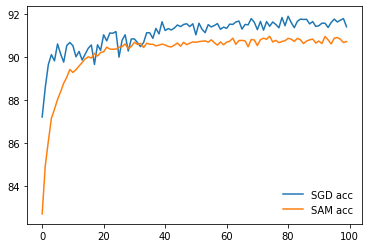

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(sgd_valid_acc, label='SGD acc')
plt.plot(sam_valid_acc, label='SAM acc')
plt.legend(frameon=False)

## Model with SGD2

In [ ]:
model_with_SGD2 = CNN().to(device)
optimizer_SGD2 = torch.optim.SGD(model_with_SGD2.parameters(), lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sgd_train_loss = []
sgd_train_acc2 = []

# sgd_valid_loss = []
sgd_valid_acc2 = []

for epoch in range(epochs*2):
    model_with_SGD2.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_SGD2.zero_grad()
        hypothesis = model_with_SGD2(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_SGD2.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # sgd_train_loss.append(total_loss / len(train_loader.dataset))     
    sgd_train_acc2.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_with_SGD2.eval()
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_with_SGD2(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # sgd_valid_loss.append(total_loss / len(valid_loader.dataset))
    sgd_valid_acc2.append(100. * correct / len(valid_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sgd_train_acc2[-1], sgd_valid_acc2[-1]))
            
        

Epoch : 1, Training Accuracy : 81.19%,  valid Accuracy : 87.42% 

Epoch : 2, Training Accuracy : 87.86%,  valid Accuracy : 88.83% 

Epoch : 3, Training Accuracy : 89.59%,  valid Accuracy : 89.82% 

Epoch : 4, Training Accuracy : 90.52%,  valid Accuracy : 90.17% 

Epoch : 5, Training Accuracy : 91.44%,  valid Accuracy : 89.89% 

Epoch : 6, Training Accuracy : 92.21%,  valid Accuracy : 90.30% 

Epoch : 7, Training Accuracy : 92.83%,  valid Accuracy : 90.63% 

Epoch : 8, Training Accuracy : 93.28%,  valid Accuracy : 90.23% 

Epoch : 9, Training Accuracy : 93.76%,  valid Accuracy : 90.27% 

Epoch : 10, Training Accuracy : 94.32%,  valid Accuracy : 90.66% 

Epoch : 11, Training Accuracy : 94.76%,  valid Accuracy : 91.29% 

Epoch : 12, Training Accuracy : 95.09%,  valid Accuracy : 90.95% 

Epoch : 13, Training Accuracy : 95.46%,  valid Accuracy : 90.26% 

Epoch : 14, Training Accuracy : 95.81%,  valid Accuracy : 90.47% 

Epoch : 15, Training Accuracy : 95.90%,  valid Accuracy : 90.40% 

Epoc

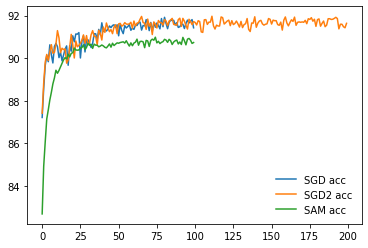

In [ ]:

plt.plot(sgd_valid_acc, label='SGD acc')
plt.plot(sgd_valid_acc2, label='SGD2 acc')
plt.plot(sam_valid_acc, label='SAM acc')
plt.legend(frameon=False)

##Model with SAM2

In [ ]:


model_with_SAM2 = CNN().to(device)

base_optimizer2 = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer_SAM2 = SAM(model_with_SAM2.parameters(), base_optimizer, lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sam_train_loss2 = []
sam_train_acc2 = []

# sam_valid_loss2 = []
sam_valid_acc2 = []


for epoch in range(epochs*2):
    
    model_with_SAM2.train()
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        # first forward-backward pass
        hypothesis = model_with_SAM2(X)
        
        loss = criterion(hypothesis, Y)  # use this loss for any training statistics
        loss.backward()
        optimizer_SAM2.first_step(zero_grad=True)

        # second forward-backward pass
        
        criterion(model_with_SAM2(X), Y).backward()  # make sure to do a full forward pass
        optimizer_SAM2.second_step(zero_grad=True)
        
        predicted = torch.argmax(hypothesis, 1)
        correct += (predicted == Y).sum().item()
        
    sam_train_acc2.append(100. * correct / len(train_loader.dataset))
    
    
    
    correct = 0
    with torch.no_grad():
        
        model_with_SAM2.eval()
        
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            hypothesis = model_with_SAM2(X)
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
    
    sam_valid_acc2.append(100. * correct / len(valid_loader.dataset))

    
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sam_train_acc2[-1], sam_valid_acc2[-1]))
        
        


Epoch : 1, Training Accuracy : 76.87%,  valid Accuracy : 85.73% 

Epoch : 2, Training Accuracy : 86.44%,  valid Accuracy : 87.72% 

Epoch : 3, Training Accuracy : 88.35%,  valid Accuracy : 88.57% 

Epoch : 4, Training Accuracy : 89.40%,  valid Accuracy : 89.12% 

Epoch : 5, Training Accuracy : 90.05%,  valid Accuracy : 89.55% 

Epoch : 6, Training Accuracy : 90.71%,  valid Accuracy : 89.89% 

Epoch : 7, Training Accuracy : 91.27%,  valid Accuracy : 90.30% 

Epoch : 8, Training Accuracy : 91.72%,  valid Accuracy : 90.26% 

Epoch : 9, Training Accuracy : 92.16%,  valid Accuracy : 90.31% 

Epoch : 10, Training Accuracy : 92.50%,  valid Accuracy : 90.42% 

Epoch : 11, Training Accuracy : 92.82%,  valid Accuracy : 90.46% 

Epoch : 12, Training Accuracy : 93.27%,  valid Accuracy : 90.69% 

Epoch : 13, Training Accuracy : 93.56%,  valid Accuracy : 90.97% 

Epoch : 14, Training Accuracy : 93.85%,  valid Accuracy : 90.93% 

Epoch : 15, Training Accuracy : 94.19%,  valid Accuracy : 91.03% 

Epoc

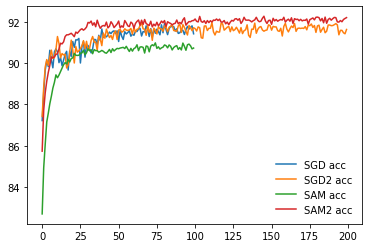

In [ ]:

plt.plot(sgd_valid_acc, label='SGD acc')
plt.plot(sgd_valid_acc2, label='SGD2 acc')
plt.plot(sam_valid_acc, label='SAM acc')
plt.plot(sam_valid_acc2, label='SAM2 acc')
plt.legend(frameon=False)

# VGG based
https://github.com/dipuk0506/SpinalNet

In [ ]:
import math

In [ ]:
class VGG(nn.Module):  
    """
    Based on - https://github.com/kkweon/mnist-competition
    from: https://github.com/ranihorev/Kuzushiji_MNIST/blob/master/KujuMNIST.ipynb
    """
    def two_conv_pool(self, in_channels, f1, f2):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s
    
    def three_conv_pool(self,in_channels, f1, f2, f3):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.Conv2d(f2, f3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s
        
    
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()
        self.l1 = self.two_conv_pool(1, 64, 64)
        self.l2 = self.two_conv_pool(64, 128, 128)
        self.l3 = self.three_conv_pool(128, 256, 256, 256)
        self.l4 = self.three_conv_pool(256, 256, 256, 256)
        
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return f.log_softmax(x, dim=1)

## VGG_SAM

In [ ]:
epochs = 50

model_VGG1 = VGG().to(device)

base_optimizer_VGG = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer_SAM_VGG = SAM(model_VGG1.parameters(), base_optimizer, lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sam_train_loss2 = []
sam_train_VGG = []

# sam_valid_loss2 = []
sam_valid_VGG = []


for epoch in range(epochs):
    
    model_VGG1.train()
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        # first forward-backward pass
        hypothesis = model_VGG1(X)
        
        loss = criterion(hypothesis, Y)  # use this loss for any training statistics
        loss.backward()
        optimizer_SAM_VGG.first_step(zero_grad=True)

        # second forward-backward pass
        
        criterion(model_VGG1(X), Y).backward()  # make sure to do a full forward pass
        optimizer_SAM_VGG.second_step(zero_grad=True)
        
        predicted = torch.argmax(hypothesis, 1)
        correct += (predicted == Y).sum().item()
        
    sam_train_VGG.append(100. * correct / len(train_loader.dataset))
    
    
    
    correct = 0
    with torch.no_grad():
        
        model_VGG1.eval()
        
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            hypothesis = model_VGG1(X)
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
    
    sam_valid_VGG.append(100. * correct / len(valid_loader.dataset))

    
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sam_train_VGG[-1], sam_valid_VGG[-1]))
        
        


Epoch : 1, Training Accuracy : 71.20%,  valid Accuracy : 84.81% 

Epoch : 2, Training Accuracy : 84.75%,  valid Accuracy : 88.00% 

Epoch : 3, Training Accuracy : 87.95%,  valid Accuracy : 89.34% 

Epoch : 4, Training Accuracy : 89.75%,  valid Accuracy : 90.23% 

Epoch : 5, Training Accuracy : 90.82%,  valid Accuracy : 90.58% 

Epoch : 6, Training Accuracy : 91.64%,  valid Accuracy : 91.31% 

Epoch : 7, Training Accuracy : 92.41%,  valid Accuracy : 91.62% 

Epoch : 8, Training Accuracy : 92.96%,  valid Accuracy : 91.47% 

Epoch : 9, Training Accuracy : 93.45%,  valid Accuracy : 92.02% 

Epoch : 10, Training Accuracy : 94.11%,  valid Accuracy : 92.19% 

Epoch : 11, Training Accuracy : 94.61%,  valid Accuracy : 92.31% 

Epoch : 12, Training Accuracy : 95.08%,  valid Accuracy : 92.58% 

Epoch : 13, Training Accuracy : 95.58%,  valid Accuracy : 92.61% 

Epoch : 14, Training Accuracy : 96.04%,  valid Accuracy : 92.72% 

Epoch : 15, Training Accuracy : 96.42%,  valid Accuracy : 93.03% 

Epoc

## VGG_SGD

In [ ]:
epochs = 50
model_VGG2 = VGG().to(device)
optimizer_SGD = torch.optim.SGD(model_VGG2.parameters(), lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sgd_train_loss = []
sgd_train_VGG = []

# sgd_valid_loss = []
sgd_valid_VGG = []

for epoch in range(epochs*2):
    model_VGG2.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_SGD.zero_grad()
        hypothesis = model_VGG2(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_SGD.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # sgd_train_loss.append(total_loss / len(train_loader.dataset))     
    sgd_train_VGG.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_VGG2.eval()
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_VGG2(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # sgd_valid_loss.append(total_loss / len(valid_loader.dataset))
    sgd_valid_VGG.append(100. * correct / len(valid_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sgd_train_VGG[-1], sgd_valid_VGG[-1]))
            
        

Epoch : 1, Training Accuracy : 72.23%,  valid Accuracy : 86.03% 

Epoch : 2, Training Accuracy : 86.13%,  valid Accuracy : 88.57% 

Epoch : 3, Training Accuracy : 88.80%,  valid Accuracy : 90.17% 

Epoch : 4, Training Accuracy : 90.66%,  valid Accuracy : 90.69% 

Epoch : 5, Training Accuracy : 92.06%,  valid Accuracy : 90.76% 

Epoch : 6, Training Accuracy : 92.94%,  valid Accuracy : 90.72% 

Epoch : 7, Training Accuracy : 94.04%,  valid Accuracy : 91.45% 

Epoch : 8, Training Accuracy : 94.94%,  valid Accuracy : 90.64% 

Epoch : 9, Training Accuracy : 95.81%,  valid Accuracy : 91.16% 

Epoch : 10, Training Accuracy : 96.50%,  valid Accuracy : 91.08% 

Epoch : 11, Training Accuracy : 96.98%,  valid Accuracy : 91.08% 

Epoch : 12, Training Accuracy : 97.53%,  valid Accuracy : 91.72% 

Epoch : 13, Training Accuracy : 97.85%,  valid Accuracy : 88.92% 

Epoch : 14, Training Accuracy : 98.01%,  valid Accuracy : 90.02% 

Epoch : 15, Training Accuracy : 98.48%,  valid Accuracy : 91.49% 

Epoc

## VGG_Adam

In [ ]:
epochs = 50
model_VGG3 = VGG().to(device)
optimizer_Adam = torch.optim.Adam(model_VGG3.parameters(), lr=learning_rate)


criterion = nn.CrossEntropyLoss()

# Adam_train_loss = []
Adam_train_VGG = []

# Adam_valid_loss = []
Adam_valid_VGG = []

for epoch in range(epochs*2):
    model_VGG3.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_Adam.zero_grad()
        hypothesis = model_VGG3(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_Adam.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # Adam_train_loss.append(total_loss / len(train_loader.dataset))     
    Adam_train_VGG.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_VGG3.eval()
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_VGG3(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # Adam_valid_loss.append(total_loss / len(valid_loader.dataset))
    Adam_valid_VGG.append(100. * correct / len(valid_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, Adam_train_VGG[-1], Adam_valid_VGG[-1]))
            
        

Epoch : 1, Training Accuracy : 83.60%,  valid Accuracy : 89.27% 

Epoch : 2, Training Accuracy : 90.05%,  valid Accuracy : 88.97% 

Epoch : 3, Training Accuracy : 91.65%,  valid Accuracy : 89.80% 

Epoch : 4, Training Accuracy : 92.96%,  valid Accuracy : 91.15% 

Epoch : 5, Training Accuracy : 93.74%,  valid Accuracy : 91.87% 

Epoch : 6, Training Accuracy : 94.66%,  valid Accuracy : 89.55% 

Epoch : 7, Training Accuracy : 95.36%,  valid Accuracy : 89.40% 

Epoch : 8, Training Accuracy : 95.73%,  valid Accuracy : 91.78% 

Epoch : 9, Training Accuracy : 96.54%,  valid Accuracy : 92.03% 

Epoch : 10, Training Accuracy : 97.10%,  valid Accuracy : 93.21% 

Epoch : 11, Training Accuracy : 97.46%,  valid Accuracy : 92.18% 

Epoch : 12, Training Accuracy : 97.84%,  valid Accuracy : 92.88% 

Epoch : 13, Training Accuracy : 98.17%,  valid Accuracy : 92.63% 

Epoch : 14, Training Accuracy : 98.30%,  valid Accuracy : 92.84% 

Epoch : 15, Training Accuracy : 98.59%,  valid Accuracy : 93.05% 

Epoc

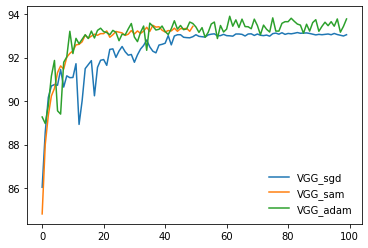

In [ ]:

plt.plot(sgd_valid_VGG, label='VGG_sgd')
plt.plot(sam_valid_VGG, label='VGG_sam')
plt.plot(Adam_valid_VGG, label='VGG_adam')
plt.legend(frameon=False)

# spinal vgg. 
https://github.com/dipuk0506/SpinalNet

In [ ]:
Half_width =128
layer_width =128

In [ ]:
class SpinalVGG(nn.Module):  
    """
    Based on - https://github.com/kkweon/mnist-competition
    from: https://github.com/ranihorev/Kuzushiji_MNIST/blob/master/KujuMNIST.ipynb
    """
    def two_conv_pool(self, in_channels, f1, f2):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s
    
    def three_conv_pool(self,in_channels, f1, f2, f3):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.Conv2d(f2, f3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s
        
    
    def __init__(self, num_classes=10):
        super(SpinalVGG, self).__init__()
        self.l1 = self.two_conv_pool(1, 64, 64)
        self.l2 = self.two_conv_pool(64, 128, 128)
        self.l3 = self.three_conv_pool(128, 256, 256, 256)
        self.l4 = self.three_conv_pool(256, 256, 256, 256)
        
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(Half_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(Half_width+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(Half_width+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(Half_width+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(layer_width*4, num_classes),)
        
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = x.view(x.size(0), -1)
        
        x1 = self.fc_spinal_layer1(x[:, 0:Half_width])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,Half_width:2*Half_width], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:Half_width], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,Half_width:2*Half_width], x3], dim=1))
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)
        
        x = self.fc_out(x)

        return f.log_softmax(x, dim=1)

## spinalVGG_sam

In [ ]:
epochs = 50

model_SpinalVGG1 = SpinalVGG().to(device)

base_optimizer_SpinalVGG = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer_SAM_SpinalVGG = SAM(model_SpinalVGG1.parameters(), base_optimizer, lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sam_train_loss2 = []
sam_train_SpinalVGG = []

# sam_valid_loss2 = []
sam_valid_SpinalVGG = []


for epoch in range(epochs*2):
    
    model_SpinalVGG1.train()
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        # first forward-backward pass
        hypothesis = model_SpinalVGG1(X)
        
        loss = criterion(hypothesis, Y)  # use this loss for any training statistics
        loss.backward()
        optimizer_SAM_SpinalVGG.first_step(zero_grad=True)

        # second forward-backward pass
        
        criterion(model_SpinalVGG1(X), Y).backward()  # make sure to do a full forward pass
        optimizer_SAM_SpinalVGG.second_step(zero_grad=True)
        
        predicted = torch.argmax(hypothesis, 1)
        correct += (predicted == Y).sum().item()
        
    sam_train_SpinalVGG.append(100. * correct / len(train_loader.dataset))
    
    
    
    correct = 0
    with torch.no_grad():
        
        model_SpinalVGG1.eval()
        
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            hypothesis = model_SpinalVGG1(X)
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
    
    sam_valid_SpinalVGG.append(100. * correct / len(valid_loader.dataset))

    
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sam_train_SpinalVGG[-1], sam_valid_SpinalVGG[-1]))
        
        


Epoch : 1, Training Accuracy : 70.97%,  valid Accuracy : 85.08% 

Epoch : 2, Training Accuracy : 85.03%,  valid Accuracy : 88.19% 

Epoch : 3, Training Accuracy : 87.94%,  valid Accuracy : 89.38% 

Epoch : 4, Training Accuracy : 89.59%,  valid Accuracy : 90.17% 

Epoch : 5, Training Accuracy : 90.65%,  valid Accuracy : 90.83% 

Epoch : 6, Training Accuracy : 91.65%,  valid Accuracy : 91.18% 

Epoch : 7, Training Accuracy : 92.41%,  valid Accuracy : 91.61% 

Epoch : 8, Training Accuracy : 93.10%,  valid Accuracy : 91.83% 

Epoch : 9, Training Accuracy : 93.65%,  valid Accuracy : 91.98% 

Epoch : 10, Training Accuracy : 94.11%,  valid Accuracy : 92.22% 

Epoch : 11, Training Accuracy : 94.70%,  valid Accuracy : 92.32% 

Epoch : 12, Training Accuracy : 95.03%,  valid Accuracy : 92.36% 

Epoch : 13, Training Accuracy : 95.58%,  valid Accuracy : 92.78% 

Epoch : 14, Training Accuracy : 95.96%,  valid Accuracy : 92.64% 

Epoch : 15, Training Accuracy : 96.39%,  valid Accuracy : 92.78% 

Epoc

## spinal vgg sgd

In [ ]:
epochs = 50
model_SpinalVGG2 = SpinalVGG().to(device)
optimizer_SGD = torch.optim.SGD(model_SpinalVGG2.parameters(), lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sgd_train_loss = []
sgd_train_SpinalVGG = []

# sgd_valid_loss = []
sgd_valid_SpinalVGG = []

for epoch in range(epochs*2):
    model_SpinalVGG2.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_SGD.zero_grad()
        hypothesis = model_SpinalVGG2(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_SGD.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # sgd_train_loss.append(total_loss / len(train_loader.dataset))     
    sgd_train_SpinalVGG.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_SpinalVGG2.eval()
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_SpinalVGG2(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # sgd_valid_loss.append(total_loss / len(valid_loader.dataset))
    sgd_valid_SpinalVGG.append(100. * correct / len(valid_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sgd_train_SpinalVGG[-1], sgd_valid_SpinalVGG[-1]))
            
        

Epoch : 1, Training Accuracy : 71.08%,  valid Accuracy : 85.69% 

Epoch : 2, Training Accuracy : 86.12%,  valid Accuracy : 88.34% 

Epoch : 3, Training Accuracy : 89.07%,  valid Accuracy : 88.78% 

Epoch : 4, Training Accuracy : 90.85%,  valid Accuracy : 90.67% 

Epoch : 5, Training Accuracy : 92.24%,  valid Accuracy : 91.14% 

Epoch : 6, Training Accuracy : 93.31%,  valid Accuracy : 90.03% 

Epoch : 7, Training Accuracy : 94.42%,  valid Accuracy : 91.21% 

Epoch : 8, Training Accuracy : 95.41%,  valid Accuracy : 91.09% 

Epoch : 9, Training Accuracy : 96.17%,  valid Accuracy : 91.33% 

Epoch : 10, Training Accuracy : 96.94%,  valid Accuracy : 91.17% 

Epoch : 11, Training Accuracy : 97.42%,  valid Accuracy : 91.15% 

Epoch : 12, Training Accuracy : 97.77%,  valid Accuracy : 91.55% 

Epoch : 13, Training Accuracy : 98.09%,  valid Accuracy : 91.49% 

Epoch : 14, Training Accuracy : 98.23%,  valid Accuracy : 91.77% 

Epoch : 15, Training Accuracy : 98.41%,  valid Accuracy : 91.03% 

Epoc

## spinal vgg adam

In [ ]:
epochs = 50
model_SpinalVGG3 = SpinalVGG().to(device)
optimizer_Adam = torch.optim.Adam(model_SpinalVGG3.parameters(), lr=learning_rate)


criterion = nn.CrossEntropyLoss()

# Adam_train_loss = []
Adam_train_SpinalVGG = []

# Adam_valid_loss = []
Adam_valid_SpinalVGG = []

for epoch in range(epochs*2):
    model_SpinalVGG3.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_Adam.zero_grad()
        hypothesis = model_SpinalVGG3(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_Adam.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # Adam_train_loss.append(total_loss / len(train_loader.dataset))     
    Adam_train_SpinalVGG.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_SpinalVGG3.eval()
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_SpinalVGG3(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # Adam_valid_loss.append(total_loss / len(valid_loader.dataset))
    Adam_valid_SpinalVGG.append(100. * correct / len(valid_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, Adam_train_SpinalVGG[-1], Adam_valid_SpinalVGG[-1]))
            
        

Epoch : 1, Training Accuracy : 83.64%,  valid Accuracy : 89.30% 

Epoch : 2, Training Accuracy : 90.08%,  valid Accuracy : 90.89% 

Epoch : 3, Training Accuracy : 91.61%,  valid Accuracy : 90.86% 

Epoch : 4, Training Accuracy : 93.04%,  valid Accuracy : 92.06% 

Epoch : 5, Training Accuracy : 93.64%,  valid Accuracy : 91.91% 

Epoch : 6, Training Accuracy : 94.82%,  valid Accuracy : 91.12% 

Epoch : 7, Training Accuracy : 95.45%,  valid Accuracy : 92.47% 

Epoch : 8, Training Accuracy : 95.97%,  valid Accuracy : 92.62% 

Epoch : 9, Training Accuracy : 96.51%,  valid Accuracy : 93.26% 

Epoch : 10, Training Accuracy : 97.32%,  valid Accuracy : 91.99% 

Epoch : 11, Training Accuracy : 97.68%,  valid Accuracy : 92.89% 

Epoch : 12, Training Accuracy : 97.81%,  valid Accuracy : 92.82% 

Epoch : 13, Training Accuracy : 98.26%,  valid Accuracy : 92.66% 

Epoch : 14, Training Accuracy : 98.48%,  valid Accuracy : 92.92% 

Epoch : 15, Training Accuracy : 98.53%,  valid Accuracy : 92.92% 

Epoc

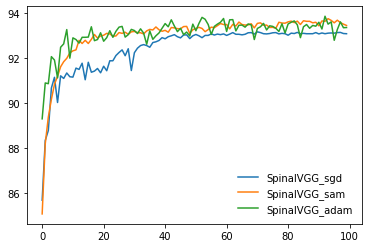

In [ ]:

plt.plot(sgd_valid_SpinalVGG, label='SpinalVGG_sgd')
plt.plot(sam_valid_SpinalVGG, label='SpinalVGG_sam')
plt.plot(Adam_valid_SpinalVGG, label='SpinalVGG_adam')
plt.legend(frameon=False)

# resnet 


In [ ]:
from torchvision.models import resnet18

## resnet_sam

In [ ]:
epochs = 50

model_resnet1 = resnet18(num_classes=10)
model_resnet1.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_resnet1.to(device)
base_optimizer_resnet = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer_SAM_resnet = SAM(model_resnet1.parameters(), base_optimizer, lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sam_train_loss2 = []
sam_train_resnet = []

# sam_valid_loss2 = []
sam_valid_resnet = []


for epoch in range(epochs*2):
    
    model_resnet1.train()
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        # first forward-backward pass
        hypothesis = model_resnet1(X)
        
        loss = criterion(hypothesis, Y)  # use this loss for any training statistics
        loss.backward()
        optimizer_SAM_resnet.first_step(zero_grad=True)

        # second forward-backward pass
        
        criterion(model_resnet1(X), Y).backward()  # make sure to do a full forward pass
        optimizer_SAM_resnet.second_step(zero_grad=True)
        
        predicted = torch.argmax(hypothesis, 1)
        correct += (predicted == Y).sum().item()
        
    sam_train_resnet.append(100. * correct / len(train_loader.dataset))
    
    
    
    correct = 0
    with torch.no_grad():
        
        model_resnet1.eval()
        
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            hypothesis = model_resnet1(X)
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
    
    sam_valid_resnet.append(100. * correct / len(valid_loader.dataset))

    
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sam_train_resnet[-1], sam_valid_resnet[-1]))
        
        


Epoch : 1, Training Accuracy : 80.75%,  valid Accuracy : 86.19% 

Epoch : 2, Training Accuracy : 86.97%,  valid Accuracy : 87.54% 

Epoch : 3, Training Accuracy : 88.79%,  valid Accuracy : 88.24% 

Epoch : 4, Training Accuracy : 90.12%,  valid Accuracy : 88.82% 

Epoch : 5, Training Accuracy : 91.15%,  valid Accuracy : 89.23% 

Epoch : 6, Training Accuracy : 91.90%,  valid Accuracy : 89.53% 

Epoch : 7, Training Accuracy : 92.65%,  valid Accuracy : 89.77% 

Epoch : 8, Training Accuracy : 93.26%,  valid Accuracy : 89.95% 

Epoch : 9, Training Accuracy : 93.84%,  valid Accuracy : 90.08% 

Epoch : 10, Training Accuracy : 94.40%,  valid Accuracy : 90.13% 

Epoch : 11, Training Accuracy : 94.94%,  valid Accuracy : 90.17% 

Epoch : 12, Training Accuracy : 95.43%,  valid Accuracy : 90.23% 

Epoch : 13, Training Accuracy : 95.91%,  valid Accuracy : 90.39% 

Epoch : 14, Training Accuracy : 96.34%,  valid Accuracy : 90.33% 

Epoch : 15, Training Accuracy : 96.76%,  valid Accuracy : 90.43% 

Epoc

KeyboardInterrupt: ignored

## resnet sgd

In [ ]:
epochs = 50
model_resnet2 = resnet18(num_classes=10)
model_resnet2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_resnet2.to(device)
optimizer_SGD = torch.optim.SGD(model_resnet2.parameters(), lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

# sgd_train_loss = []
sgd_train_resnet = []

# sgd_valid_loss = []
sgd_valid_resnet = []

for epoch in range(epochs):
    model_resnet2.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_SGD.zero_grad()
        hypothesis = model_resnet2(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_SGD.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # sgd_train_loss.append(total_loss / len(train_loader.dataset))     
    sgd_train_resnet.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_resnet2.eval()
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_resnet2(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # sgd_valid_loss.append(total_loss / len(valid_loader.dataset))
    sgd_valid_resnet.append(100. * correct / len(valid_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, sgd_train_resnet[-1], sgd_valid_resnet[-1]))
            
        

Epoch : 1, Training Accuracy : 82.08%,  valid Accuracy : 85.98% 

Epoch : 2, Training Accuracy : 88.69%,  valid Accuracy : 87.57% 

Epoch : 3, Training Accuracy : 91.74%,  valid Accuracy : 87.88% 

Epoch : 4, Training Accuracy : 94.23%,  valid Accuracy : 87.82% 

Epoch : 5, Training Accuracy : 95.75%,  valid Accuracy : 87.38% 

Epoch : 6, Training Accuracy : 96.53%,  valid Accuracy : 87.49% 

Epoch : 7, Training Accuracy : 97.02%,  valid Accuracy : 87.98% 

Epoch : 8, Training Accuracy : 97.06%,  valid Accuracy : 87.30% 

Epoch : 9, Training Accuracy : 97.33%,  valid Accuracy : 88.24% 

Epoch : 10, Training Accuracy : 97.87%,  valid Accuracy : 87.61% 

Epoch : 11, Training Accuracy : 97.92%,  valid Accuracy : 88.56% 

Epoch : 12, Training Accuracy : 98.38%,  valid Accuracy : 87.89% 

Epoch : 13, Training Accuracy : 98.56%,  valid Accuracy : 88.33% 

Epoch : 14, Training Accuracy : 98.69%,  valid Accuracy : 88.33% 

Epoch : 15, Training Accuracy : 98.86%,  valid Accuracy : 88.58% 

Epoc

## resnet adam

In [ ]:
epochs = 50
model_resnet3 = resnet18(num_classes=10)
model_resnet3.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_resnet3.to(device)
optimizer_Adam = torch.optim.Adam(model_resnet3.parameters(), lr=learning_rate)


criterion = nn.CrossEntropyLoss()

# Adam_train_loss = []
Adam_train_resnet = []

# Adam_valid_loss = []
Adam_valid_resnet = []

for epoch in range(epochs):
    model_resnet3.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_Adam.zero_grad()
        hypothesis = model_resnet3(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_Adam.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # Adam_train_loss.append(total_loss / len(train_loader.dataset))     
    Adam_train_resnet.append(100. * correct / len(train_loader.dataset))        
        
    
    
    # total_loss = 0
    correct = 0
    
    with torch.no_grad():
        model_resnet3.eval()
        for X, Y in valid_loader:
            X = X.to(device)
            Y = Y.to(device)
        
            hypothesis = model_resnet3(X)
            
            # total_loss += loss.item()
            predicted = torch.argmax(hypothesis, 1)
            correct += (predicted == Y).sum().item()
            
            
    # Adam_valid_loss.append(total_loss / len(valid_loader.dataset))
    Adam_valid_resnet.append(100. * correct / len(valid_loader.dataset))         
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}%,  valid Accuracy : {:.2f}% \n'.format(
        epoch+1, Adam_train_resnet[-1], Adam_valid_resnet[-1]))
            
        

Epoch : 1, Training Accuracy : 83.56%,  valid Accuracy : 85.17% 

Epoch : 2, Training Accuracy : 88.39%,  valid Accuracy : 88.63% 

Epoch : 3, Training Accuracy : 90.27%,  valid Accuracy : 89.18% 

Epoch : 4, Training Accuracy : 91.22%,  valid Accuracy : 89.05% 

Epoch : 5, Training Accuracy : 92.28%,  valid Accuracy : 88.47% 

Epoch : 6, Training Accuracy : 93.06%,  valid Accuracy : 89.32% 

Epoch : 7, Training Accuracy : 93.75%,  valid Accuracy : 87.69% 

Epoch : 8, Training Accuracy : 94.31%,  valid Accuracy : 89.03% 

Epoch : 9, Training Accuracy : 94.83%,  valid Accuracy : 89.33% 

Epoch : 10, Training Accuracy : 95.41%,  valid Accuracy : 88.76% 

Epoch : 11, Training Accuracy : 95.98%,  valid Accuracy : 88.46% 

Epoch : 12, Training Accuracy : 96.31%,  valid Accuracy : 89.78% 

Epoch : 13, Training Accuracy : 96.63%,  valid Accuracy : 89.64% 

Epoch : 14, Training Accuracy : 97.00%,  valid Accuracy : 90.05% 

Epoch : 15, Training Accuracy : 97.37%,  valid Accuracy : 89.28% 

Epoc

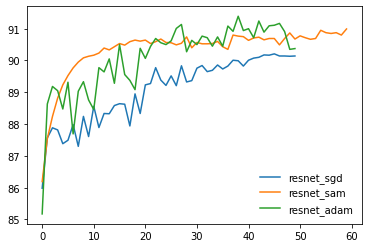

In [ ]:

plt.plot(sgd_valid_resnet, label='resnet_sgd')
plt.plot(sam_valid_resnet, label='resnet_sam')
plt.plot(Adam_valid_resnet, label='resnet_adam')
plt.legend(frameon=False)

# majority voting & save

In [ ]:
from scipy.stats import mode


In [ ]:
qqq= []

In [ ]:
tes= [1,2,2,4,4,4,4,5,6]
qqq.extend(mode(tes)[0])
qqq.append(1)

In [ ]:
qqq

[4, 1]

In [ ]:
classifiers = [
model_with_SGD,
model_with_SAM,
model_with_SGD2,
model_with_SAM2,
model_VGG1,
model_VGG2,
model_VGG3,
model_SpinalVGG1,
model_SpinalVGG2,
model_SpinalVGG3,
model_resnet1,
model_resnet2,
model_resnet3,
]

In [ ]:
def test_fun(model):
  pred = []
  with torch.no_grad():
      correct = 0
      total = 0
      for image in test_loader:
          image = image.to(device)

          outputs = model(image)

          predicted = np.asarray(torch.argmax(outputs, dim=1).cpu())
          pred.append(predicted)
  
  print(np.array(pred).flatten().shape)
  return np.array(pred).flatten()

In [ ]:
out = []
for model in classifiers:
  out.append(test_fun(model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)


In [ ]:
total = []
for idx in range(len(out)):
  test = pd.DataFrame()
  test['label'] = out[idx]
  temp = []
  for i in range(len(test)):
    temp.extend(test.iloc[i].tolist()[0])
  total.append(temp)

In [ ]:
total_pred = []
for i in range(len(total[0])): # i 번쨰 데이터
  temp = []
  for j in range(len(total)): # j 번째 classifier
    temp.append(total[j][i])
  total_pred.extend(mode(temp)[0])


In [ ]:
df_sub = pd.read_csv("/content/drive/MyDrive/personal/fashion_mnist/data/sample_submission.csv")

In [ ]:
df_sub

,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
9995,9995,0
9996,9996,0
9997,9997,0
9998,9998,0


In [ ]:
df_sub['label'] = total_pred

In [ ]:
df_sub.to_csv("/content/drive/MyDrive/personal/fashion_mnist/data/sample_submission_ensemble.csv", index=False)
# accuracy = 0.942

# VGG Adam
Train best model with whole training set

In [ ]:
train_all = pd.read_csv("/content/drive/MyDrive/personal/fashion_mnist/data/train.csv", index_col='index')
Train_data_all = train_Dataset(train_all, transform=transform)
train_all_loader = torch.utils.data.DataLoader(Train_data_all, batch_size=batch_size, shuffle=False)

In [ ]:
len(Train_data_all)

60000

In [ ]:
epochs = 50
model_VGG4 = VGG().to(device)
optimizer_Adam = torch.optim.Adam(model_VGG4.parameters(), lr=learning_rate)


criterion = nn.CrossEntropyLoss()

# Adam_train_loss = []
Adam_train_VGG2 = []


for epoch in range(epochs*2):
    model_VGG4.train()
    
    total_loss = 0
    correct = 0
    
    for X, Y in train_all_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer_Adam.zero_grad()
        hypothesis = model_VGG4(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer_Adam.step()
        
        # total_loss += loss.item()
        predicted = torch.argmax(hypothesis, 1)
        
        correct += (predicted == Y).sum().item()

    # Adam_train_loss.append(total_loss / len(train_loader.dataset))     
    Adam_train_VGG2.append(100. * correct / len(train_all_loader.dataset))        
                 
            
    
    print('Epoch : {}, Training Accuracy : {:.2f}% \n'.format(
        epoch+1, Adam_train_VGG2[-1]))
            
        

Epoch : 1, Training Accuracy : 84.67% 

Epoch : 2, Training Accuracy : 90.35% 

Epoch : 3, Training Accuracy : 91.95% 

Epoch : 4, Training Accuracy : 93.07% 

Epoch : 5, Training Accuracy : 93.99% 

Epoch : 6, Training Accuracy : 94.85% 

Epoch : 7, Training Accuracy : 95.72% 

Epoch : 8, Training Accuracy : 96.24% 

Epoch : 9, Training Accuracy : 96.98% 

Epoch : 10, Training Accuracy : 97.41% 

Epoch : 11, Training Accuracy : 97.78% 

Epoch : 12, Training Accuracy : 98.01% 

Epoch : 13, Training Accuracy : 98.24% 

Epoch : 14, Training Accuracy : 98.56% 

Epoch : 15, Training Accuracy : 98.75% 

Epoch : 16, Training Accuracy : 98.81% 

Epoch : 17, Training Accuracy : 98.97% 

Epoch : 18, Training Accuracy : 98.99% 

Epoch : 19, Training Accuracy : 99.11% 

Epoch : 20, Training Accuracy : 99.27% 

Epoch : 21, Training Accuracy : 99.29% 

Epoch : 22, Training Accuracy : 99.26% 

Epoch : 23, Training Accuracy : 99.20% 

Epoch : 24, Training Accuracy : 99.39% 

Epoch : 25, Training Accu

In [ ]:
vgg4_out = test_fun(model_VGG4)
test2 = pd.DataFrame()
test2['label'] = vgg4_out
temp2 = []
for i in range(len(test2)):
  temp2.extend(test.iloc[i].tolist()[0])

(157,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [ ]:
df_sub2= pd.read_csv("/content/drive/MyDrive/personal/fashion_mnist/data/sample_submission.csv")

In [ ]:
df_sub2['label'] = temp2

In [ ]:
df_sub2.to_csv("/content/drive/MyDrive/personal/fashion_mnist/data/sample_submission_vgg_adam.csv", index=False)
# accuracy = 0.9089